# Week 17
## Ensemble Learning and Random Forest

In [44]:
# Dependencies and modules:

import pandas as pd
from pandas import Int64Index as NumericIndex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from pprint import pp

from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours


from sklearn.svm import SVC

## 1. What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.

Deductive reasoning is a logical top-down path where you start with a known, evaluate new information, and follow that information to its logical conclusion. For example, if you know I have three things in my pocket and I pull out a Swiss army knife and a roll of duct tape, you can deduce that I now have one thing in my pocket. 

Inductive reasoning is more bottom-up thinking. You see the hole that was in my hot air balloon is now patched with duct-tape. Then you see that the access panel on the burner has been opened via removal of it's six screws and some faulty wiring has been cut, stripped, and re-connected. You see a Swiss army knife on the floor of the basket surrounded by six screws. You can reason from these observations that I had at least two things in my pocket when boarding the hot air balloon.

## Using ONE of the following sources, complete the questions for only that source. 

Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29

Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 

Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.

#### Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.


### Reading in files and creating a dataframe of the data:

In [45]:
# The download consisted of a .names file and a .data file. I will extract column names
# from the .name file for the dataframe that will wold the .data data.

with open("abalone.names") as f:
    print(f.read())

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

In [62]:
# abalone.csv
abalone_df = pd.read_csv('abalone.data',header=None, names=['Sex',
                                                            'Length',
                                                            'Diameter',
                                                            'Height',
                                                            'Whole weight',
                                                            'Shucked weight',
                                                            'Viscera weight',
                                                            'Shell weight',
                                                            'Rings',])
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## 2. Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t. 

Here is a recap of various pre-processing we have done over the last month:
* NaN handling (columns vs. rows, fillna vs. dropna, imputation)
* data type handling
* Imbalanced Learning (stratified sampling, oversampling, undersampling)
* outlier detection and/or removal
* standardizing data (regularization, normalizing, scaling)
* feature engineering (categorical vs. numerical vs. strings, binary vs. one-hot, average vs. datetime, extraction vs. tf/idf)
* feature selection (redundant, correlated, dimensionality reduction)

This dataset comes with some pre-processing already done. There are no NaNs, datatypes are numerical (except for sex), and data has been scaled. I will verify these points:

In [63]:
# Verifying documentation-asserted pre-processing:
print('Data variance: ')
print(abalone_df.var(numeric_only=True))
print(' ')
print("Data NaNs: ")
print(abalone_df.isnull().sum().sort_values())
print(' ')
print('Data Types: ')
print(abalone_df.dtypes)

Data variance: 
Length             0.014422
Diameter           0.009849
Height             0.001750
Whole weight       0.240481
Shucked weight     0.049268
Viscera weight     0.012015
Shell weight       0.019377
Rings             10.395266
dtype: float64
 
Data NaNs: 
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64
 
Data Types: 
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


I first want to create a new column for age, as it is our output variable. Per the dataset documentation, abalone age in years is equal to Rings + 1.5. Then I will factorize the sex column. After that, I will check a heatmap to visualize feature correlation. Then I want to check for outliers with a quick box plot; I can think of scenarious where outliers could be present (an abalone that lived for many years with its length constrained because it was tangled in a plastic net or something). After I scrub outliers, I will perform SMOTEEN. Then I will perform a statistical feature selection. I will check performance of preprocessing with a quick linear regression model at each stage.

In [65]:
# Age column creation and replacement of Rings column:
abalone_df['Age in years'] = abalone_df['Rings']+1.5
abalone = abalone_df.drop('Rings', axis=1)
abalone.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age in years
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5


In [66]:
#abalone_df['Coded Sex'] = pd.factorize(abalone_df['Sex'])
# Factorizing the sex column:
column = ['Sex']
for i in column:
    abalone["Coded "+i] = pd.factorize(abalone[i])[0]+1
    code_key = pd.DataFrame(abalone[i])
    code_key["Code for "+i]=abalone["Coded "+i]
    abalone = abalone.drop(i,axis=1)
    print(code_key[[i,"Code for "+i]].value_counts())
# preserving a key of sex codes for reference:
# sex_codes = pd.DataFrame(abalone_df[['Coded Sex','Sex']]).unique
# sex_codes
#abalone_df

Sex  Code for Sex
M    1               1528
I    3               1342
F    2               1307
dtype: int64


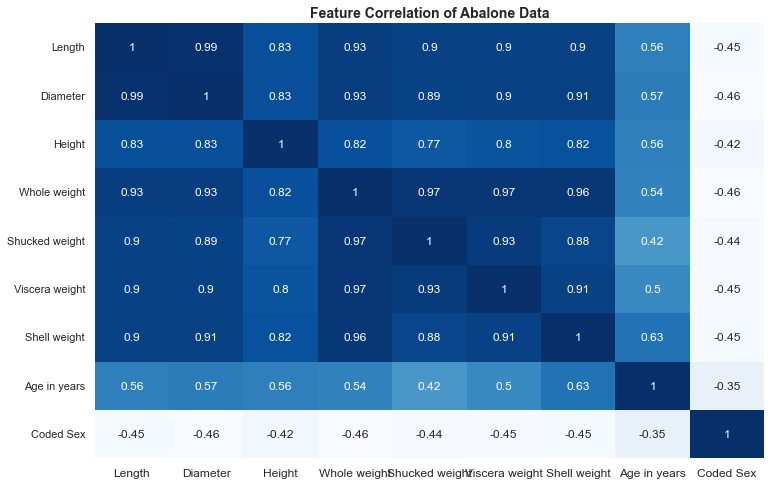

In [72]:
# plotting the heatmap
correlation = abalone.corr()
g = sns.heatmap(correlation, annot=True, linewidth=0, cmap="Blues",cbar=False)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 12)
g.set_title('Feature Correlation of Abalone Data',size=14, weight='bold')
sns.set(rc={'figure.figsize':(12,8)})

Obviously the many weight columns have strong multicolinnearity. I will have to cull those down. Then I can use a statistical feature selector.

## 3. Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

## 4. Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

## 5. Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

## 7. Which model performed best? What is your performance metric? Why? 

# DataCamp Completions: